# AAE364 Grand Prix

This notebook is a go-kart race simulation. You must design the steering controller.

![GoKart](fig/grandprix_d.jpg)

## Mathematical Model

You control:
1. The steering angle of the wheel, $\delta$.

You are given:
1. The error across the track direction, $e_x$.

The equations of motion are non-linear but can be approximated as linear:

$\ddot{x} = \dfrac{V^2}{l} \delta$

You are expected to use matlab/python to design a lead-lad or PID compensator.

## Filtering

There are added disturbances and noise. These function from scipy signals may be helpful for designing filters to cope with the noise. Remember you can only increase your gain to compensate for disturance.

* [elliptical filter design](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html#scipy.signal.ellip)
* [butterworth filter design](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter)


## Extra Credit

Each submitted controller will be scored using the distance travelled using the simulator during a fixed amount of time. The max speed is set at 10 m/s, the radius of the track is 1 m, and the time is set to $2\pi/10$, therefore, the most you can achieve is about one lap in the time allotted, or about $6.28$ m, unless you get clever.

You will receive extra credit by the following table:

1. Top 25 \% of the class: 3 points extra credit
1. Top 50 \% of the class: 2 points extra credit
1. Top 75 \% of the class: 1 points extra credit

## Setup

* If you don't have python on your computer and wish to install it, I recommend using [Anaconda](www.anaconda.com).
* You may also run python remotely using [Google Colab](https://colab.research.google.com).

To get started, you will need to install the control library and any other missing libraries.

```bash
pip install control
```

Or, if you prefer conda:

```bash
conda install control
```

Next, you will need to download these scripts:

* [grandprix.py](./grandprix.py): This contains the simulators and control code you will need. To use it, see the example below.
* [grandprix_template.py](./grandprix_template.py): Modify this and rename it: grandprix_your_name.py, where your is your first name, and name is your last name as used on blackboard.

## Submission

To submit your script for grading, upload your Controller in a standalone file named 'grandprix_firstname_lastname.py' to blackboard make sure it follows the format below. Only change the section that say " WRITE YOUR... HERE". I will download all of the uploaded scripts and then use your name from the script to automatically grade your, so make sure you follow the format given exactly. You may work as individuals or teams. If you work as a team, upload the script with the name above for each team member.

In [4]:
%cat grandprix_template.py

from grandprix import DiscreteStateSpace
import numpy as np
import control
import scipy

class Controller:
  """
  You must design a controller using a PID or lead-lag controller or
  a set or any combination of these controller to design the best
  control system possible that drives the race course without
  leaving the track.
  """
  
  def __init__(self, dt):
    """
    @param dt: the update rate of the controller
    """
    self.dt = dt

    ###
    ### WRITE YOUR OWN CONTROLLERS HERE
    ###
    s = control.tf([1, 0], [0, 1])
    
    H = 0.1 + 0/s + 2*s*10/(s+10)
    self.ex_steering = DiscreteStateSpace(H, dt)

    # don't change this
    self.desired_speed = 10
  
  def update(self, error, velocity):
    """
    current state:
    @param error: [etheta, ex, ey]
    @param velocity: how fast you are moving, m/s
    
    ouput
    @param throttle: the throttle to the motor, commands velocity m/s
    @param steering: the steering angle of the vehicle in radians
    """
    ethe

# Example Controller

Here we test the template controller, try to do better.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


sim initialized
sim started
CRASH at time     0.0220 seconds


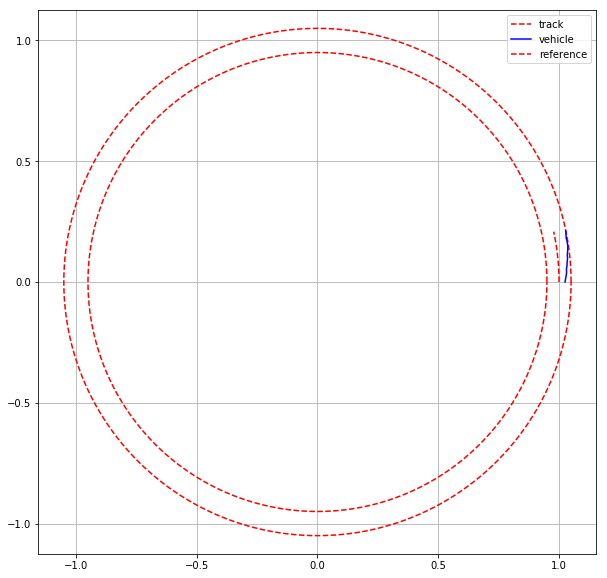

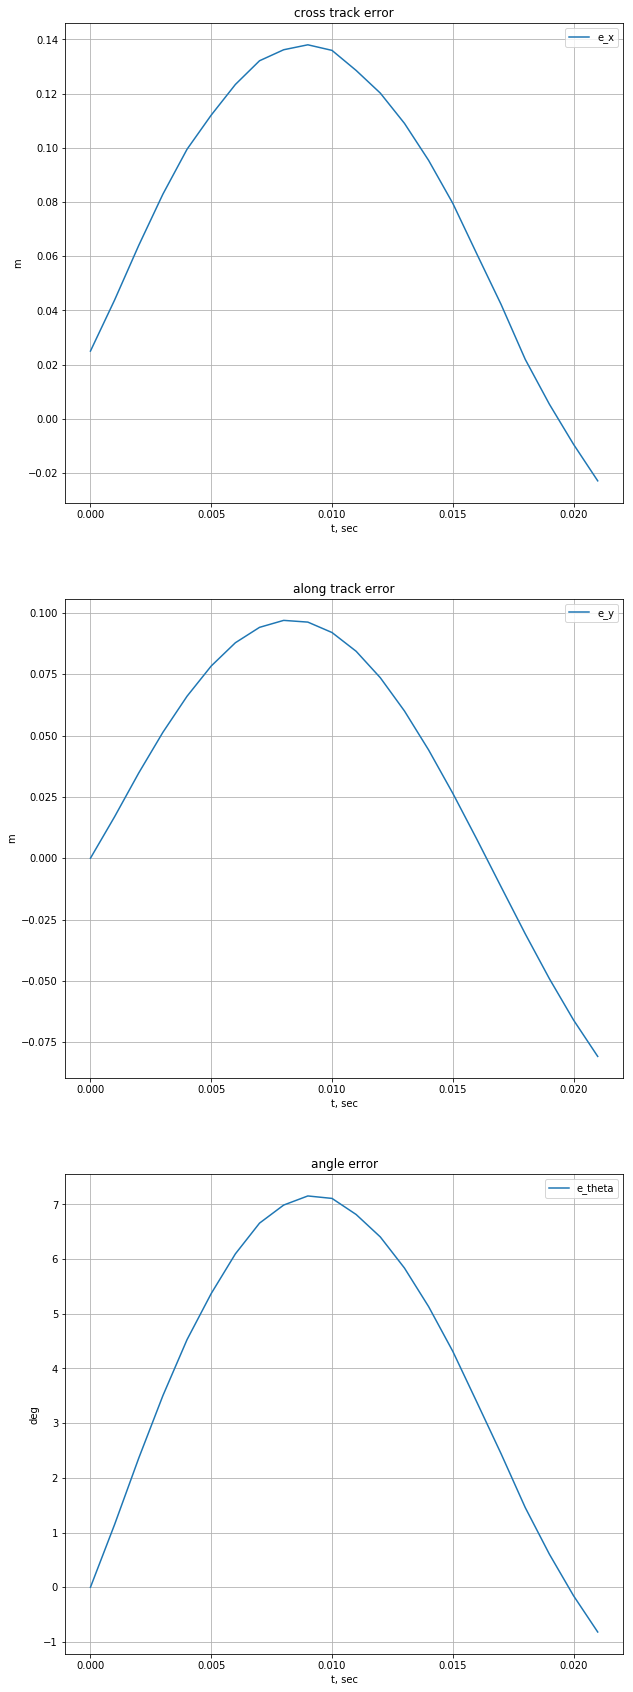

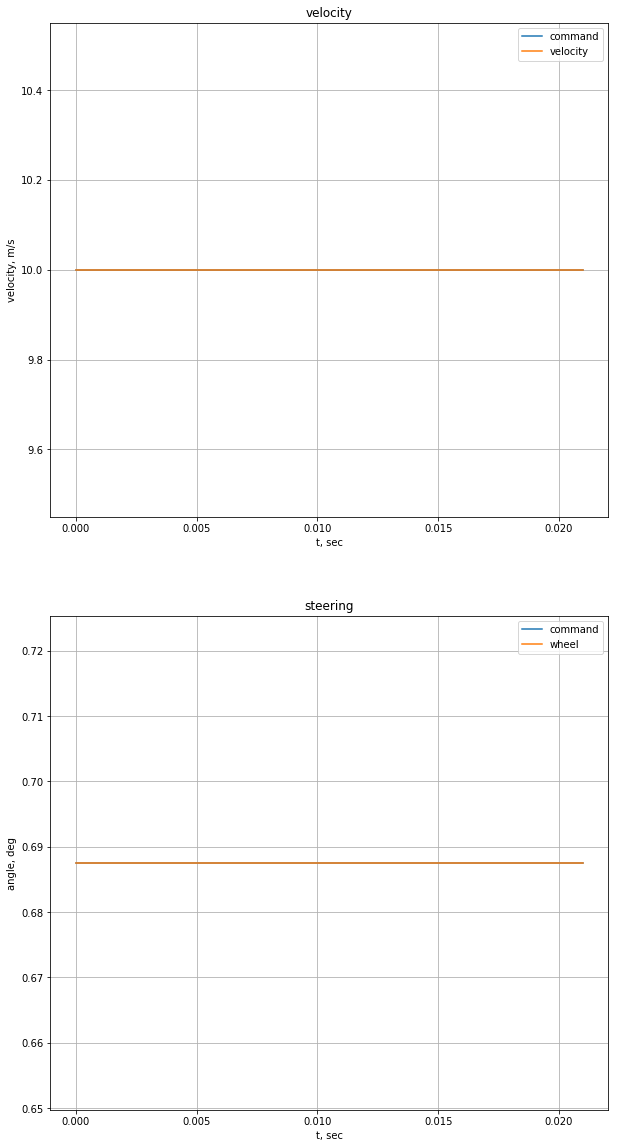

In [6]:
import sys
sys.path.insert(0, '../prob/grandprix')
from grandprix import Sim, DiscreteStateSpace
from grandprix_template import Controller
#from grandprix_example import Controller

sim = Sim(Controller, verbose=True)
sim.run()
sim.plot()